Importing modules

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import os
from IPython import display

Collecting Data

In [ ]:
link_to_data='https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/cityscapes.tar.gz'
zip_path=tf.keras.utils.get_file('cityscapes.tar.gz',origin=link_to_data,extract=True)
path=os.path.join(os.path.dirname(zip_path),'cityscapes/')

103448576/103441232 [==============================] - 2s 0us/step


In [ ]:
print(path)
os.chdir(path)
os.listdir()

/root/.keras/datasets/cityscapes/


['val', 'train']

In [ ]:
train_path=os.path.join(path,'train/')
test_path=os.path.join(path,'val/')
print(train_path)
print(test_path)

/root/.keras/datasets/cityscapes/train/
/root/.keras/datasets/cityscapes/val/


(256, 512, 3)


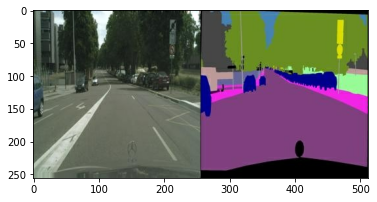

In [ ]:
os.chdir('train')
os.listdir()[1]
img=tf.io.read_file('2206.jpg')
img=tf.image.decode_jpeg(img)
print(img.shape)
plt.imshow(img)

In [ ]:
def splitting_input_output(path):
  img=tf.io.read_file(path)
  img=tf.image.decode_jpeg(img)
  output_img=img[:,0:256,:]
  input_img=img[:,256:,]
  input_img = tf.cast(input_img, tf.float32)
  output_img = tf.cast(output_img, tf.float32)
  return input_img,output_img

In [ ]:
def normalize(input_img,output_img):
  input_img=(input_img-127.5)/127.5
  output_img=(output_img-127.5)/127.5
  return input_img,output_img

In [ ]:
def resize(input_img,output_img,height,width):
  input_img=tf.image.resize(input_img,[height,width],method='nearest')
  output_img=tf.image.resize(output_img,[height,width],method='nearest')
  return input_img,output_img

In [ ]:
def random_cropping(input_img,output_img):
  stack=tf.stack([input_img,output_img],axis=0)
  cropped_image = tf.image.random_crop(
      stack, size=[2, 256, 256, 3])
  return cropped_image[0],cropped_image[1]

In [ ]:
def load_train_set(image_path):
  input_img,output_img=splitting_input_output(image_path)
  input_img,output_img=normalize(input_img,output_img)
  input_img,output_img=resize(input_img,output_img,286,286)
  input_img,output_img=random_cropping(input_img,output_img)
  return input_img,output_img

In [ ]:
def load_test_set(image_path):
  input_img,output_img=splitting_input_output(image_path)
  input_img,output_img=normalize(input_img,output_img)
  return input_img,output_img


Converting to tf dataset

In [ ]:
BUFFER_SIZE=512
BATCH_SIZE=1
train_dataset=tf.data.Dataset.list_files(train_path+'*.jpg')
print(next(iter(train_dataset)))
train_dataset=train_dataset.map(load_train_set,num_parallel_calls=tf.data.experimental.AUTOTUNE)
trian_dataset=train_dataset.shuffle(BUFFER_SIZE)
train_dataset=train_dataset.batch(BATCH_SIZE)
test_dataset=tf.data.Dataset.list_files(test_path+'*.jpg')
test_dataset=test_dataset.map(load_test_set)
test_dataset=test_dataset.batch(BATCH_SIZE)

tf.Tensor(b'/root/.keras/datasets/cityscapes/train/1883.jpg', shape=(), dtype=string)


In [ ]:
print(type(next(iter(train_dataset))[0]))

<class 'tensorflow.python.framework.ops.EagerTensor'>


**Training_architecture**

In [ ]:
def downsample_block(filters,size,apply_batchnorm=True):
  block=tf.keras.Sequential()
  block.add(layers.Conv2D(filters,size,strides=(2,2),padding='same',use_bias=False))
  if apply_batchnorm:
    block.add(layers.BatchNormalization())
  block.add(layers.ReLU())
  return block

In [ ]:
input_=next(iter(train_dataset))[0]

In [ ]:
down_model = downsample_block(3, 4)
down_result = down_model(input_)
print (down_result.shape)

(1, 128, 128, 3)


In [ ]:
def upsample_block(filters,size):
  block=tf.keras.Sequential()
  block.add(layers.Conv2DTranspose(filters,size,padding='same',strides=(2,2)))
  block.add(layers.ReLU())
  block.add(layers.Dropout(0.3))
  return block

In [ ]:
up_model=upsample_block(3,4)
up_result=up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [ ]:
def Generator():
  input_tensor=tf.keras.layers.Input(shape=(256,256,3))
  downsample_models=[
                     downsample_block(32,4),# 128,128,32
                     downsample_block(64,4),# 64 ,64 64
                     downsample_block(128,4), #32,32 128
                     downsample_block(128,4), #16,16,128
                     downsample_block(256,4), # 8,8 256
                     downsample_block(256,4),# 4,4,256
                     downsample_block(512,4),# 2,2,512
                     downsample_block(512,4) #1,1,512
  ]
  upsample_models=[
                   upsample_block(512,4),
                   upsample_block(256,4),
                   upsample_block(256,4),
                   upsample_block(128,4),
                   upsample_block(128,4),
                   upsample_block(64,4),
                   upsample_block(32,4) # 128,128,64
  ]
  x=input_tensor
  skip=[]
  for model in downsample_models:
    x=model(x,training=True)
    skip.append(x)

  for i,model in enumerate(upsample_models):
    x=model(x,training=True)
    x=tf.keras.layers.Concatenate()([x,skip[6-i]])
  x=layers.Conv2DTranspose(3,4,strides=(2,2),padding='same',use_bias=False)(x)
  Model=tf.keras.Model(inputs=input_tensor,outputs=x)
  return Model


In [ ]:
gen_example=Generator()

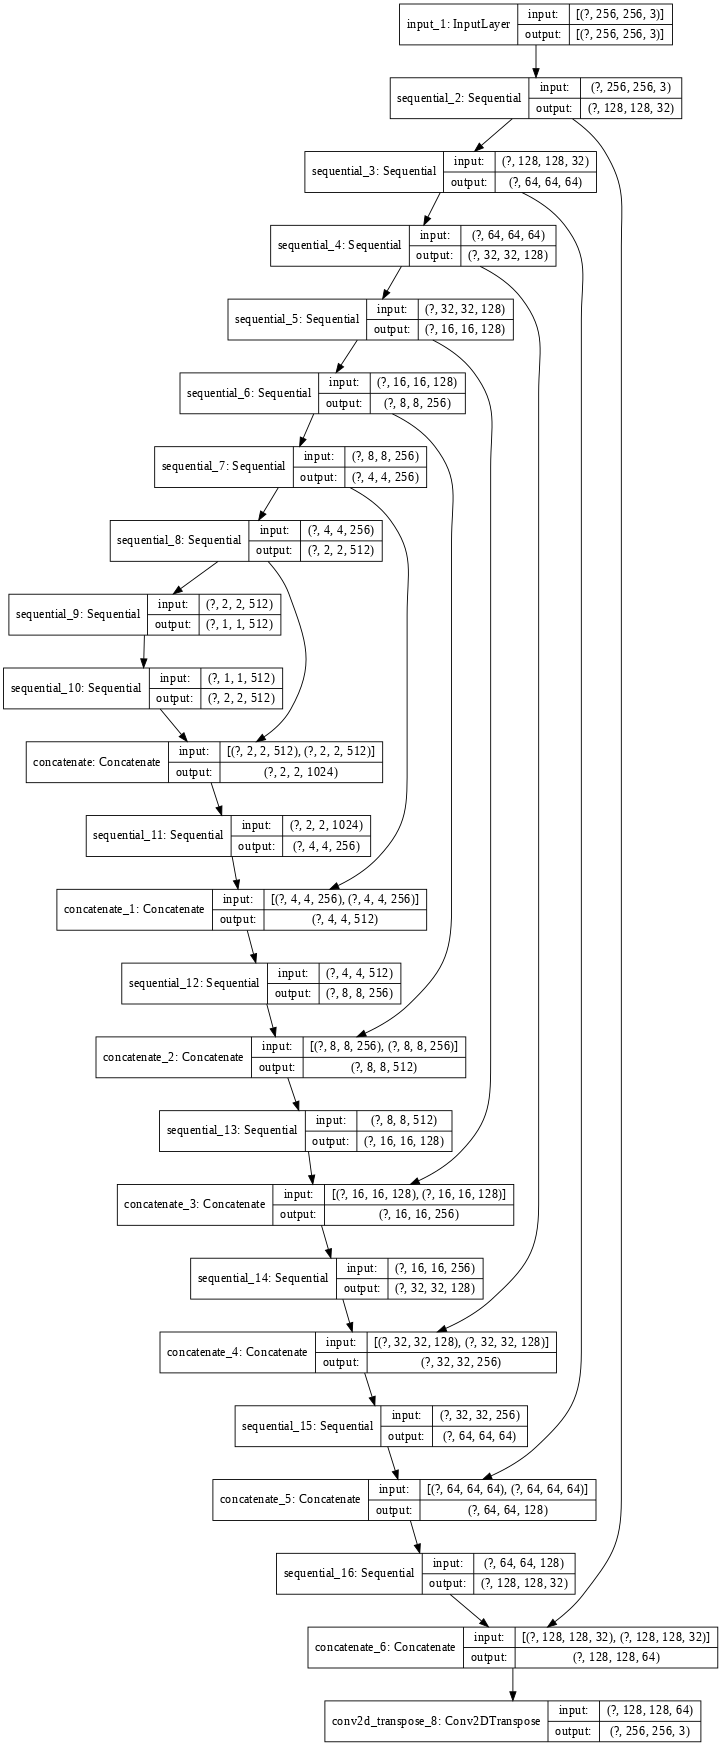

In [ ]:
tf.keras.utils.plot_model(gen_example, show_shapes=True, dpi=64)

In [ ]:
def Discriminator():
  #initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample_block(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample_block(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample_block(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,activation='sigmoid')(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [ ]:
Crossentropy_loss=tf.keras.losses.BinaryCrossentropy()
Mean_absolute_error=tf.keras.losses.MeanAbsoluteError()

In [ ]:
def generator_loss(gen_img,target_img,dis_gen_img):
  l1_loss=100*(Mean_absolute_error(target_img,gen_img))
  discriminator_loss=Crossentropy_loss(tf.ones_like(dis_gen_img),dis_gen_img)
  return l1_loss+discriminator_loss

In [ ]:
try_example=(tf.random.normal([1,256,256,3]),tf.random.normal([1,256,256,3]),tf.random.normal([1,30,30,1]))
print(generator_loss(*try_example))

tf.Tensor(120.83842, shape=(), dtype=float32)


In [ ]:
def discriminator_loss(gen_img,target_img):
  fake_loss=Crossentropy_loss(tf.ones_like(target_img),target_img)
  real_loss=Crossentropy_loss(tf.zeros_like(gen_img),gen_img)
  return fake_loss+real_loss

In [ ]:
def generate(model,input_img,target_img):
  result=model(input_img,training=True)
  plt.subplot(1,3,1)
  plt.imshow(input_img[0]*0.5+0.5)
  plt.subplot(1,3,2)
  plt.imshow(result[0]*0.5+0.5)
  plt.subplot(1,3,3)
  plt.imshow(target_img[0]*0.5+0.5)
  plt.show()
  return result

In [ ]:
gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(input_img,target_img):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    output_img=generator(input_img,training=True)
    disc_target_img=discriminator([input_img,target_img],training=True)
    disc_gen_img=discriminator([input_img,output_img],training=True)
    gen_loss=generator_loss(output_img,target_img,disc_gen_img)
    disc_loss=discriminator_loss(disc_gen_img,disc_target_img)
  gen_gradients=gen_tape.gradient(gen_loss,generator.trainable_variables)
  disc_gradients=disc_tape.gradient(disc_loss,discriminator.trainable_variables)
  gen_optimizer.apply_gradients(zip(gen_gradients,generator.trainable_variables))
  disc_optimizer.apply_gradients(zip(disc_gradients,discriminator.trainable_variables))



In [ ]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in enumerate(train_ds):
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target)
    print()
    
  

In [ ]:
generator=Generator()
discriminator=Discriminator()

**Training of Cityscape Dataset**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


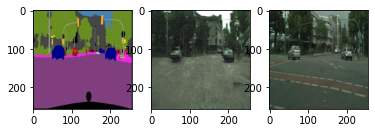

Epoch:  49
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................................................................................

In [ ]:
fit(train_dataset,50,test_dataset)

In [ ]:
next(iter(test_dataset))[1].shape

TensorShape([1, 256, 256, 3])